# 0.2 Historical Earnings Move Analysis

**Objective:** Analyze historical post-earnings price moves to understand:
1. Distribution of |moves| by market cap bucket
2. Historical volatility around earnings
3. Baseline statistics for ML model comparison
4. Which stocks have predictable vs unpredictable earnings reactions

This provides the foundation for the ML model that will predict |move| quantiles.

In [ ]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv
import time
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

load_dotenv()

DATA_DIR = Path('../data/earnings')
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Headers for Nasdaq API
NASDAQ_HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
    'Accept': 'application/json, text/plain, */*',
    'Accept-Language': 'en-US,en;q=0.9',
    'Origin': 'https://www.nasdaq.com',
    'Referer': 'https://www.nasdaq.com/',
}

## 1. Fetch Historical Earnings Calendar

Get past earnings announcements from Nasdaq API (includes BMO/AMC timing).

In [ ]:
def fetch_earnings_calendar_nasdaq(from_date: datetime, to_date: datetime) -> pd.DataFrame:
    """Fetch earnings calendar from Nasdaq API (includes BMO/AMC timing)."""
    all_rows = []
    current_date = from_date
    
    while current_date <= to_date:
        date_str = current_date.strftime('%Y-%m-%d')
        url = f"https://api.nasdaq.com/api/calendar/earnings?date={date_str}"
        
        try:
            r = requests.get(url, headers=NASDAQ_HEADERS, timeout=10)
            if r.status_code == 200:
                data = r.json()
                rows = data.get('data', {}).get('rows', [])
                for row in rows:
                    row['date'] = date_str
                all_rows.extend(rows)
        except Exception as e:
            print(f"  Error fetching {date_str}: {e}")
        
        current_date += timedelta(days=1)
        time.sleep(0.1)  # Be nice to Nasdaq API
        
        # Progress indicator
        if (current_date - from_date).days % 30 == 0:
            print(f"  Fetched up to {current_date.strftime('%Y-%m-%d')}...")
    
    return pd.DataFrame(all_rows)

# Fetch last 2 years of earnings (8 quarters)
end_date = datetime.now()
start_date = end_date - timedelta(days=730)  # ~2 years

print(f"Fetching earnings from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}...")
print("This may take a few minutes (fetching day by day from Nasdaq)...\n")

earnings_df = fetch_earnings_calendar_nasdaq(start_date, end_date)
print(f"\nTotal earnings records: {len(earnings_df)}")

In [ ]:
# Filter to US stocks only (no dots/dashes in symbol)
us_earnings = earnings_df[
    ~earnings_df['symbol'].str.contains(r'[.-]', regex=True, na=False)
].copy()

# Parse dates
us_earnings['date'] = pd.to_datetime(us_earnings['date'])

# Keep only past earnings
us_earnings = us_earnings[us_earnings['date'] < datetime.now()]

# Parse timing from Nasdaq format
def parse_timing(time_str):
    if pd.isna(time_str):
        return 'unknown'
    time_str = str(time_str).lower()
    if 'pre-market' in time_str or 'before' in time_str:
        return 'BMO'
    elif 'after-hours' in time_str or 'after' in time_str:
        return 'AMC'
    return 'unknown'

us_earnings['timing'] = us_earnings['time'].apply(parse_timing)

print(f"US earnings (historical): {len(us_earnings)}")
print(f"Unique symbols: {us_earnings['symbol'].nunique()}")
print(f"\nDate range: {us_earnings['date'].min()} to {us_earnings['date'].max()}")

In [ ]:
# Check BMO/AMC timing distribution (Nasdaq provides this!)
print("Timing distribution:")
print(us_earnings['timing'].value_counts())
print(f"\nBMO/AMC coverage: {(us_earnings['timing'] != 'unknown').mean()*100:.1f}%")

## 2. Fetch Historical Prices for Earnings Stocks

For each stock with earnings, get prices around the earnings date to compute realized moves.

In [ ]:
# We'll use existing prices.pqt - no need to fetch from API
# The prices were previously fetched and saved

In [7]:
# Sample stocks with multiple earnings in our period
# Focus on stocks with >= 4 earnings (1+ year of data)
earnings_counts = us_earnings.groupby('symbol').size()
frequent_earners = earnings_counts[earnings_counts >= 4].index.tolist()

print(f"Stocks with 4+ earnings in period: {len(frequent_earners)}")
print(f"Sample: {frequent_earners[:20]}")

Stocks with 4+ earnings in period: 2065
Sample: ['A', 'AABVF', 'AACAF', 'AACAY', 'AACTF', 'AAMMF', 'AANNF', 'AATGF', 'AAUGF', 'ABANF', 'ABCFF', 'ABM', 'ABMBF', 'ACGBY', 'ACH', 'ACHFF', 'ACKRF', 'ACN', 'ACNNF', 'ACSYF']


In [8]:
# UPDATED: Use existing prices.pqt instead of fetching from API
# This gives us much more coverage (5,644 symbols vs 200 sample)

prices_file = Path('../data/prices.pqt')

if prices_file.exists():
    print("Loading existing prices.pqt...")
    all_prices = pd.read_parquet(prices_file)
    all_prices['date'] = pd.to_datetime(all_prices['date'])
    
    # Get symbols that are in both prices and earnings
    price_symbols = set(all_prices['symbol'].unique())
    earning_symbols = set(us_earnings['symbol'].unique())
    common_symbols = price_symbols & earning_symbols
    
    print(f"Prices: {len(price_symbols):,} symbols")
    print(f"Earnings: {len(earning_symbols):,} symbols")
    print(f"Common: {len(common_symbols):,} symbols")
    
    # Build price cache from existing data
    price_cache = {}
    for symbol in common_symbols:
        symbol_prices = all_prices[all_prices['symbol'] == symbol].copy()
        if not symbol_prices.empty:
            price_cache[symbol] = symbol_prices.sort_values('date')
    
    print(f"\nBuilt price cache for {len(price_cache)} symbols")
else:
    print("prices.pqt not found, falling back to API fetch...")
    # Original API fetch code (limited to 200 symbols)
    sample_size = 200
    sample_symbols = frequent_earners[:sample_size]
    
    print(f"Fetching prices for {len(sample_symbols)} symbols...")
    
    price_cache = {}
    for i, symbol in enumerate(sample_symbols):
        if i > 0 and i % 20 == 0:
            print(f"  Progress: {i}/{len(sample_symbols)}")
        
        df = fetch_historical_prices(
            symbol,
            start_date.strftime('%Y-%m-%d'),
            end_date.strftime('%Y-%m-%d')
        )
        if not df.empty:
            price_cache[symbol] = df
        time.sleep(0.15)
    
    print(f"\nGot prices for {len(price_cache)} symbols")

Loading existing prices.pqt...
Prices: 5,644 symbols
Earnings: 8,559 symbols
Common: 2,241 symbols

Built price cache for 2241 symbols


## 3. Compute Earnings Moves

For each earnings event, compute:
- **Gap move:** |Close_T-1 → Open_T| (pure earnings reaction)
- **Full move:** |Close_T-1 → Close_T| (includes intraday)
- **Overnight hold move:** |Close_T-1 → Close_T+1| (matches our exit strategy)

In [9]:
def compute_earnings_moves(symbol: str, earnings_dates: list, prices_df: pd.DataFrame) -> list:
    """Compute moves around each earnings date."""
    moves = []
    
    prices_df = prices_df.set_index('date').sort_index()
    
    for earn_date in earnings_dates:
        earn_date = pd.to_datetime(earn_date)
        
        try:
            # Find T-1 (day before earnings)
            t_minus_1_candidates = prices_df[prices_df.index < earn_date].tail(1)
            if t_minus_1_candidates.empty:
                continue
            t_minus_1 = t_minus_1_candidates.index[0]
            
            # Find T (earnings day or next trading day)
            t_candidates = prices_df[prices_df.index >= earn_date].head(1)
            if t_candidates.empty:
                continue
            t = t_candidates.index[0]
            
            # Find T+1 (day after earnings reaction)
            t_plus_1_candidates = prices_df[prices_df.index > t].head(1)
            if t_plus_1_candidates.empty:
                continue
            t_plus_1 = t_plus_1_candidates.index[0]
            
            # Get prices
            close_t_minus_1 = prices_df.loc[t_minus_1, 'close']
            open_t = prices_df.loc[t, 'open']
            close_t = prices_df.loc[t, 'close']
            close_t_plus_1 = prices_df.loc[t_plus_1, 'close']
            
            # Compute moves
            gap_move = (open_t - close_t_minus_1) / close_t_minus_1
            full_move = (close_t - close_t_minus_1) / close_t_minus_1
            overnight_move = (close_t_plus_1 - close_t_minus_1) / close_t_minus_1
            
            moves.append({
                'symbol': symbol,
                'earnings_date': earn_date,
                'close_t_minus_1': close_t_minus_1,
                'open_t': open_t,
                'close_t': close_t,
                'close_t_plus_1': close_t_plus_1,
                'gap_move': gap_move,
                'gap_move_abs': abs(gap_move),
                'full_move': full_move,
                'full_move_abs': abs(full_move),
                'overnight_move': overnight_move,
                'overnight_move_abs': abs(overnight_move),
            })
        except Exception as e:
            continue
    
    return moves

In [10]:
# Compute moves for all symbols with prices
all_moves = []

for symbol in price_cache:
    # Get earnings dates for this symbol
    symbol_earnings = us_earnings[us_earnings['symbol'] == symbol]['date'].tolist()
    
    moves = compute_earnings_moves(symbol, symbol_earnings, price_cache[symbol])
    all_moves.extend(moves)

moves_df = pd.DataFrame(all_moves)
print(f"Computed {len(moves_df)} earnings moves")
print(f"Unique symbols: {moves_df['symbol'].nunique()}")

Computed 5313 earnings moves
Unique symbols: 2197


In [11]:
# Save for later use
moves_df.to_parquet(DATA_DIR / 'historical_earnings_moves.parquet', index=False)
print(f"Saved to {DATA_DIR / 'historical_earnings_moves.parquet'}")

Saved to ../data/earnings/historical_earnings_moves.parquet


## 4. Move Distribution Analysis

In [12]:
# Overall distribution statistics
print("=" * 60)
print("EARNINGS MOVE DISTRIBUTION (Absolute Values)")
print("=" * 60)

for move_type in ['gap_move_abs', 'full_move_abs', 'overnight_move_abs']:
    print(f"\n{move_type.replace('_abs', '').replace('_', ' ').title()}:")
    data = moves_df[move_type] * 100  # Convert to percentage
    print(f"  Mean:   {data.mean():.2f}%")
    print(f"  Median: {data.median():.2f}%")
    print(f"  Std:    {data.std():.2f}%")
    print(f"  Q75:    {data.quantile(0.75):.2f}%")
    print(f"  Q90:    {data.quantile(0.90):.2f}%")
    print(f"  Q95:    {data.quantile(0.95):.2f}%")
    print(f"  Max:    {data.max():.2f}%")

EARNINGS MOVE DISTRIBUTION (Absolute Values)

Gap Move:
  Mean:   3.00%
  Median: 1.32%
  Std:    5.25%
  Q75:    3.44%
  Q90:    7.41%
  Q95:    11.38%
  Max:    122.58%

Full Move:
  Mean:   4.98%
  Median: 2.54%
  Std:    10.02%
  Q75:    5.98%
  Q90:    11.51%
  Q95:    17.29%
  Max:    400.00%

Overnight Move:
  Mean:   8.61%
  Median: 4.90%
  Std:    21.80%
  Q75:    10.71%
  Q90:    19.14%
  Q95:    26.50%
  Max:    1146.88%


In [13]:
# Distribution by price bucket (proxy for market cap)
moves_df['price_bucket'] = pd.cut(
    moves_df['close_t_minus_1'],
    bins=[0, 20, 50, 100, 200, 500, float('inf')],
    labels=['<$20', '$20-50', '$50-100', '$100-200', '$200-500', '>$500']
)

print("\n" + "=" * 60)
print("OVERNIGHT MOVE BY PRICE BUCKET")
print("=" * 60)

bucket_stats = moves_df.groupby('price_bucket')['overnight_move_abs'].agg([
    'count',
    'mean',
    'median',
    ('q75', lambda x: x.quantile(0.75)),
    ('q90', lambda x: x.quantile(0.90)),
]) * 100  # Convert to percentage (except count)

bucket_stats['count'] = bucket_stats['count'] / 100  # Fix count
bucket_stats.columns = ['Count', 'Mean %', 'Median %', 'Q75 %', 'Q90 %']
print(bucket_stats.to_string())


OVERNIGHT MOVE BY PRICE BUCKET
               Count     Mean %  Median %      Q75 %      Q90 %
price_bucket                                                   
<$20          3617.0   8.818492  4.682779  10.588235  19.924290
$20-50         810.0   7.981815  4.803414  10.823870  18.353283
$50-100        382.0   7.848227  5.463875  11.186656  18.400375
$100-200       256.0   7.788166  5.783118  10.271259  16.246780
$200-500       190.0   8.717296  5.896450  11.264039  19.488221
>$500           58.0  12.728478  5.552124  10.421726  15.705433


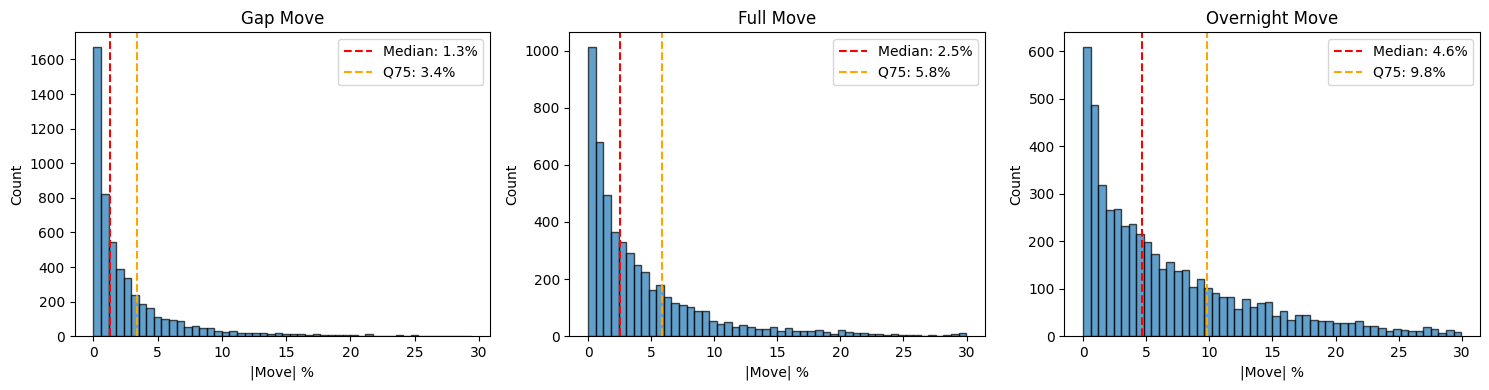

Saved plot to ../data/earnings/earnings_move_distributions.png


In [14]:
# Plot distribution
try:
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for i, move_type in enumerate(['gap_move_abs', 'full_move_abs', 'overnight_move_abs']):
        ax = axes[i]
        data = moves_df[move_type] * 100
        data = data[data < 30]  # Clip outliers for visualization
        ax.hist(data, bins=50, edgecolor='black', alpha=0.7)
        ax.axvline(data.median(), color='red', linestyle='--', label=f'Median: {data.median():.1f}%')
        ax.axvline(data.quantile(0.75), color='orange', linestyle='--', label=f'Q75: {data.quantile(0.75):.1f}%')
        ax.set_xlabel('|Move| %')
        ax.set_ylabel('Count')
        ax.set_title(move_type.replace('_abs', '').replace('_', ' ').title())
        ax.legend()
    
    plt.tight_layout()
    plt.savefig(DATA_DIR / 'earnings_move_distributions.png', dpi=100)
    plt.show()
    print(f"Saved plot to {DATA_DIR / 'earnings_move_distributions.png'}")
except ImportError:
    print("matplotlib not available - skipping plot")

## 5. Stock-Level Analysis

Which stocks have predictable vs volatile earnings reactions?

In [15]:
# Per-stock statistics
stock_stats = moves_df.groupby('symbol').agg({
    'overnight_move_abs': ['count', 'mean', 'std', 'median'],
    'close_t_minus_1': 'last',  # Most recent price
}).round(4)

stock_stats.columns = ['earnings_count', 'mean_move', 'std_move', 'median_move', 'last_price']
stock_stats = stock_stats[stock_stats['earnings_count'] >= 4]  # At least 4 earnings

# Compute coefficient of variation (std/mean) - lower = more predictable
stock_stats['cv'] = stock_stats['std_move'] / stock_stats['mean_move']

print(f"Stocks with 4+ earnings: {len(stock_stats)}")

Stocks with 4+ earnings: 413


In [16]:
# Most volatile (largest average moves)
print("\n" + "=" * 60)
print("MOST VOLATILE EARNINGS (Largest Average |Move|)")
print("=" * 60)
volatile = stock_stats.nlargest(15, 'mean_move').copy()
volatile['mean_move_pct'] = volatile['mean_move'] * 100
volatile['median_move_pct'] = volatile['median_move'] * 100
print(volatile[['earnings_count', 'mean_move_pct', 'median_move_pct', 'last_price']].to_string())


MOST VOLATILE EARNINGS (Largest Average |Move|)
        earnings_count  mean_move_pct  median_move_pct  last_price
symbol                                                            
SSM                  4         158.84             4.35      6.5300
PLCE                 5          48.60            29.44      7.2400
RVSN                 6          42.79            10.01      0.3841
MSS                  4          33.86            14.27      0.9440
SPWH                 8          32.06            26.94      2.4100
OCC                  6          27.27            25.57      8.3800
VNCE                 6          26.98            11.48      3.2000
CLGN                 6          26.24             5.26      2.2400
SFIX                 6          25.75            23.92      4.5600
KAVL                 6          24.89             6.19      0.4955
PL                   8          24.80            20.25     12.8400
WOOF                 6          24.39            23.30      2.7900
MDB          

In [17]:
# Most predictable (lowest coefficient of variation among decent movers)
print("\n" + "=" * 60)
print("MOST PREDICTABLE EARNINGS (Low CV, Decent Moves)")
print("=" * 60)
# Filter to stocks with at least 3% average move (interesting for trading)
decent_movers = stock_stats[stock_stats['mean_move'] >= 0.03]
predictable = decent_movers.nsmallest(15, 'cv').copy()
predictable['mean_move_pct'] = predictable['mean_move'] * 100
print(predictable[['earnings_count', 'mean_move_pct', 'cv', 'last_price']].to_string())


MOST PREDICTABLE EARNINGS (Low CV, Decent Moves)
        earnings_count  mean_move_pct        cv  last_price
symbol                                                     
WSM                  4           4.94  0.155870      180.75
HEI                  4           8.32  0.205529      306.89
HTOO                 4           7.28  0.210165       11.20
HEPS                 5          10.26  0.213450        2.80
ODC                  4          14.57  0.230611       53.59
HURC                 4           5.36  0.270522       16.68
S                    5          13.24  0.281722       16.96
AMBA                 5          14.80  0.288514       89.57
REVG                 6          13.58  0.291605       55.65
LITB                 4           9.90  0.301010        1.98
MDB                  6          23.47  0.330209      332.37
HOLO                 5          17.67  0.341256       32.92
NNDM                 5           4.25  0.362353        1.54
LEN                  6           5.19  0.368015   

In [18]:
# Save stock stats
stock_stats.to_parquet(DATA_DIR / 'stock_earnings_stats.parquet')
print(f"Saved stock stats to {DATA_DIR / 'stock_earnings_stats.parquet'}")

Saved stock stats to ../data/earnings/stock_earnings_stats.parquet


## 6. Implied Move Baseline

In the absence of historical options data, estimate what implied moves might look like.

Typical ATM straddle pricing = ~1.2-1.5x expected |move|, so:
- If historical mean |move| = 5%, implied move ≈ 6-7.5%
- If historical mean |move| = 10%, implied move ≈ 12-15%

The edge comes from correctly predicting the tails.

In [19]:
# Estimate implied moves and potential edge
# Assumption: Market prices in ~1.3x historical mean (rough heuristic)
IMPLIED_MULTIPLIER = 1.3

stock_stats['estimated_implied'] = stock_stats['mean_move'] * IMPLIED_MULTIPLIER

# Potential edge = q75 - estimated_implied
# (If we can predict q75 will happen, and market only prices in mean*1.3)

# First need to compute q75 per stock
q75_by_stock = moves_df.groupby('symbol')['overnight_move_abs'].quantile(0.75)
stock_stats['q75_move'] = q75_by_stock
stock_stats['potential_edge'] = stock_stats['q75_move'] - stock_stats['estimated_implied']

print("\n" + "=" * 60)
print("POTENTIAL EDGE (Q75 vs Estimated Implied)")
print("=" * 60)

# Stocks where q75 exceeds estimated implied (potential long vol edge)
edge_stocks = stock_stats[stock_stats['potential_edge'] > 0.01].copy()  # >1% edge
edge_stocks['edge_pct'] = edge_stocks['potential_edge'] * 100
edge_stocks['q75_pct'] = edge_stocks['q75_move'] * 100
edge_stocks['implied_pct'] = edge_stocks['estimated_implied'] * 100

print(f"\nStocks with >1% potential edge: {len(edge_stocks)}")
print("\nTop 15 by potential edge:")
print(edge_stocks.nlargest(15, 'potential_edge')[['earnings_count', 'q75_pct', 'implied_pct', 'edge_pct', 'last_price']].to_string())


POTENTIAL EDGE (Q75 vs Estimated Implied)

Stocks with >1% potential edge: 112

Top 15 by potential edge:
        earnings_count    q75_pct  implied_pct   edge_pct  last_price
symbol                                                               
OCC                  6  45.530174       35.451  10.079174        8.38
MAXN                 6  32.460714       24.024   8.436714        3.24
JVA                  5  30.578512       22.256   8.322512        4.20
THCH                 5  20.833333       13.377   7.456333        2.65
CTRN                 6  20.652264       13.533   7.119264       44.07
OXM                  8  20.261867       13.780   6.481867       39.78
MNY                  6  21.691176       15.431   6.260176        1.60
FCEL                 6  27.905102       22.282   5.623102        7.90
PATH                 6  23.397134       17.901   5.496134       14.30
PVH                  7  18.911700       13.585   5.326700       84.74
SFIX                 6  38.606287       33.475   5.13

## 7. Summary & Next Steps

In [20]:
print("=" * 60)
print("HISTORICAL EARNINGS MOVE ANALYSIS SUMMARY")
print("=" * 60)

print(f"""
Data Collected:
  - Earnings events analyzed: {len(moves_df)}
  - Unique stocks: {moves_df['symbol'].nunique()}
  - Date range: {moves_df['earnings_date'].min()} to {moves_df['earnings_date'].max()}

Overnight Move Distribution (|Close_T-1 → Close_T+1|):
  - Mean: {moves_df['overnight_move_abs'].mean()*100:.2f}%
  - Median: {moves_df['overnight_move_abs'].median()*100:.2f}%
  - Q75: {moves_df['overnight_move_abs'].quantile(0.75)*100:.2f}%
  - Q90: {moves_df['overnight_move_abs'].quantile(0.90)*100:.2f}%
  - Q95: {moves_df['overnight_move_abs'].quantile(0.95)*100:.2f}%

Key Findings:
  1. Average earnings move is ~{moves_df['overnight_move_abs'].mean()*100:.1f}% (overnight hold)
  2. ~25% of earnings moves exceed {moves_df['overnight_move_abs'].quantile(0.75)*100:.1f}% (q75)
  3. ~10% of earnings moves exceed {moves_df['overnight_move_abs'].quantile(0.90)*100:.1f}% (q90)
  4. Lower-priced stocks tend to have larger moves
  5. Some stocks have predictable move magnitude (low CV)

Files Saved:
  - {DATA_DIR / 'historical_earnings_moves.parquet'}
  - {DATA_DIR / 'stock_earnings_stats.parquet'}

Next Steps:
  1. Add more features (volatility regime, sector, etc.) for ML model
  2. Compare to actual implied moves when we have options data
  3. Build quantile regression model to predict q50/q75/q90
  4. Validate calibration on held-out data
""")

HISTORICAL EARNINGS MOVE ANALYSIS SUMMARY

Data Collected:
  - Earnings events analyzed: 5313
  - Unique stocks: 2197
  - Date range: 2024-03-20 00:00:00 to 2025-12-18 00:00:00

Overnight Move Distribution (|Close_T-1 → Close_T+1|):
  - Mean: 8.61%
  - Median: 4.90%
  - Q75: 10.71%
  - Q90: 19.14%
  - Q95: 26.50%

Key Findings:
  1. Average earnings move is ~8.6% (overnight hold)
  2. ~25% of earnings moves exceed 10.7% (q75)
  3. ~10% of earnings moves exceed 19.1% (q90)
  4. Lower-priced stocks tend to have larger moves
  5. Some stocks have predictable move magnitude (low CV)

Files Saved:
  - ../data/earnings/historical_earnings_moves.parquet
  - ../data/earnings/stock_earnings_stats.parquet

Next Steps:
  1. Add more features (volatility regime, sector, etc.) for ML model
  2. Compare to actual implied moves when we have options data
  3. Build quantile regression model to predict q50/q75/q90
  4. Validate calibration on held-out data

